# Calculate cosine similarity by noise ablation on embeddings

This notebook walks through extracting generated embeddings from noise ablation and calculating per-chip cosine similarity between the base embeddings and different types of ablation. These are then aggregated per class to quantify how sensitive the embeddings of each class are for each model to different bands. A KS test is applied to test whether ablated embeddings are significantly different from non-ablated embeddings.

In [ ]:
# imports
from gelos.embedding_extraction import extract_embeddings
from gelos.tsne_transform import tsne_from_embeddings, save_tsne_as_csv
from gelos.plotting import plot_from_tsne, legend_patches
from gelos.embedding_generation import perturb_args_to_string
import geopandas as gpd
import yaml
from gelos.config import PROJ_ROOT, PROCESSED_DATA_DIR, DATA_VERSION, RAW_DATA_DIR
from gelos.config import REPORTS_DIR, FIGURES_DIR
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

2025-12-10 02:30:32.747 | INFO     | gelos.config:<module>:16 - PROJ_ROOT path is: /app


/opt/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 2.0.8 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations


In [15]:
from sklearn.metrics.pairwise import cosine_similarity

## Define parameters for embedding extraction from multiple ablation types

In [3]:
model_name = "prithvieov2300"
yaml_dir = PROJ_ROOT / "gelos" / "configs"
yaml_paths = list(yaml_dir.glob(f"*{model_name}*"))

In [4]:
yaml_path = yaml_paths[0]

In [12]:
embeddings_dict = {}
for yaml_path in yaml_paths:
    with open(yaml_path, "r") as f:
        yaml_config = yaml.safe_load(f)
    print(yaml.dump(yaml_config))

    data_root = RAW_DATA_DIR / DATA_VERSION
    chip_gdf = gpd.read_file(data_root / 'gelos_chip_tracker.geojson')
    figures_dir = FIGURES_DIR / DATA_VERSION
    figures_dir.mkdir(exist_ok=True, parents=True)

    model_name = yaml_config['model']['init_args']['model']
    model_title = yaml_config['model']['title']
    embedding_extraction_strategies = yaml_config['embedding_extraction_strategies']
    perturb = yaml_config['data']['init_args'].get('perturb_bands', None)
    perturb_string = perturb_args_to_string(perturb)
    output_dir = PROCESSED_DATA_DIR / DATA_VERSION / model_name / perturb_string

    embeddings_directories = [item for item in output_dir.iterdir() if item.is_dir()]
    for embeddings_directory in embeddings_directories:
        embedding_layer = embeddings_directory.stem
        extraction_strategy = "CLS Token"
        slice_args = embedding_extraction_strategies[extraction_strategy]

        model_title_lower = model_title.replace(" ", "").lower()
        extraction_strategy_lower = extraction_strategy.replace(" ", "").lower()
        embedding_layer_lower = embedding_layer.replace("_", "").lower()
        print(f"processing embeddings for {perturb_string}")

        embeddings, chip_indices = extract_embeddings(
            embeddings_directory,
            slice_args=slice_args
            )
        embeddings_dict[perturb_string] = embeddings


data:
  class_path: gelos.gelosdatamodule.GELOSDataModule
  init_args:
    bands:
      S2L2A:
      - BLUE
      - GREEN
      - RED
      - NIR_NARROW
      - SWIR_1
      - SWIR_2
    batch_size: 1
    num_workers: 2
    perturb_bands:
      S2L2A:
        BLUE: 0.1
    transform:
    - class_path: terratorch.datasets.transforms.FlattenTemporalIntoChannels
    - class_path: albumentations.pytorch.transforms.ToTensorV2
    - class_path: terratorch.datasets.transforms.UnflattenTemporalFromChannels
      init_args:
        n_timesteps: 4
embedding_extraction_strategies:
  All Patches from April to June:
  - start: 37
    step: 1
    stop: 73
  All Steps of Middle Patch:
  - start: 19
    step: 36
    stop: null
  CLS Token:
  - start: 0
    step: 1
    stop: 1
model:
  class_path: terratorch.tasks.EmbeddingGenerationTask
  init_args:
    embed_file_key: filename
    embedding_pooling: null
    has_cls: true
    layers:
    - -1
    model: prithvi_eo_v2_300
    model_args:
      bands:


Processing embeddings: 60507it [03:31, 285.74it/s]


data:
  class_path: gelos.gelosdatamodule.GELOSDataModule
  init_args:
    bands:
      S2L2A:
      - BLUE
      - GREEN
      - RED
      - NIR_NARROW
      - SWIR_1
      - SWIR_2
    batch_size: 1
    num_workers: 0
    transform:
    - class_path: terratorch.datasets.transforms.FlattenTemporalIntoChannels
    - class_path: albumentations.pytorch.transforms.ToTensorV2
    - class_path: terratorch.datasets.transforms.UnflattenTemporalFromChannels
      init_args:
        n_timesteps: 4
embedding_extraction_strategies:
  All Patches from April to June:
  - start: 37
    step: 1
    stop: 73
  All Steps of Middle Patch:
  - start: 19
    step: 36
    stop: null
  CLS Token:
  - start: 0
    step: 1
    stop: 1
model:
  class_path: terratorch.tasks.EmbeddingGenerationTask
  init_args:
    embed_file_key: filename
    embedding_pooling: null
    has_cls: true
    layers:
    - -1
    model: prithvi_eo_v2_300
    model_args:
      bands:
      - BLUE
      - GREEN
      - RED
      - NIR

Processing embeddings: 60507it [03:56, 255.33it/s]


data:
  class_path: gelos.gelosdatamodule.GELOSDataModule
  init_args:
    bands:
      S2L2A:
      - BLUE
      - GREEN
      - RED
      - NIR_NARROW
      - SWIR_1
      - SWIR_2
    batch_size: 1
    num_workers: 2
    perturb_bands:
      S2L2A:
        NIR_NARROW: 0.1
    transform:
    - class_path: terratorch.datasets.transforms.FlattenTemporalIntoChannels
    - class_path: albumentations.pytorch.transforms.ToTensorV2
    - class_path: terratorch.datasets.transforms.UnflattenTemporalFromChannels
      init_args:
        n_timesteps: 4
embedding_extraction_strategies:
  All Patches from April to June:
  - start: 37
    step: 1
    stop: 73
  All Steps of Middle Patch:
  - start: 19
    step: 36
    stop: null
  CLS Token:
  - start: 0
    step: 1
    stop: 1
model:
  class_path: terratorch.tasks.EmbeddingGenerationTask
  init_args:
    embed_file_key: filename
    embedding_pooling: null
    has_cls: true
    layers:
    - -1
    model: prithvi_eo_v2_300
    model_args:
      b

Processing embeddings: 60507it [04:47, 210.52it/s]


In [ ]:
n_samples =

In [22]:
for k, v in embeddings_dict.items():
    n_samples, embed_dim = v.shape
    print(k)
    print(v.shape)

s2l2ablue0.1perturb
(60507, 1024)
noperturb
(60507, 1024)
s2l2anir_narrow0.1perturb
(60507, 1024)


In [24]:
cosine_simalarities = {}
for perturb in embeddings_dict.keys():
    if perturb == "noperturb":
        continue
    perturb_embeddings = embeddings_dict[perturb]
    control_embeddings = embeddings_dict["noperturb"]
    cosine_simalarities[perturb] = np.array([
        cosine_similarity(perturb_embeddings[i, :].reshape(1, -1), control_embeddings[i, :].reshape(1, -1)).diagonal()
        for i in tqdm(range(n_samples))
    ])




































































































































































100%|██████████| 60507/60507 [00:16<00:00, 3690.89it/s]

























































































































































100%|██████████| 60507/60507 [00:15<00:00, 3942.00it/s]


In [28]:
for ablation, similarities in cosine_simalarities.items():
    chip_gdf[ablation] = similarities 

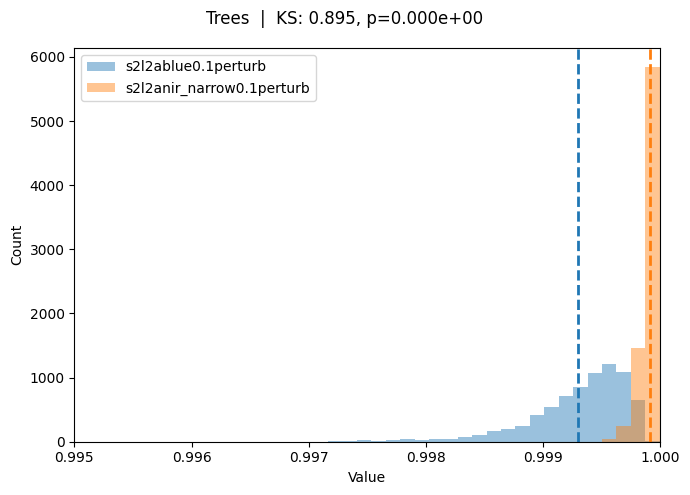

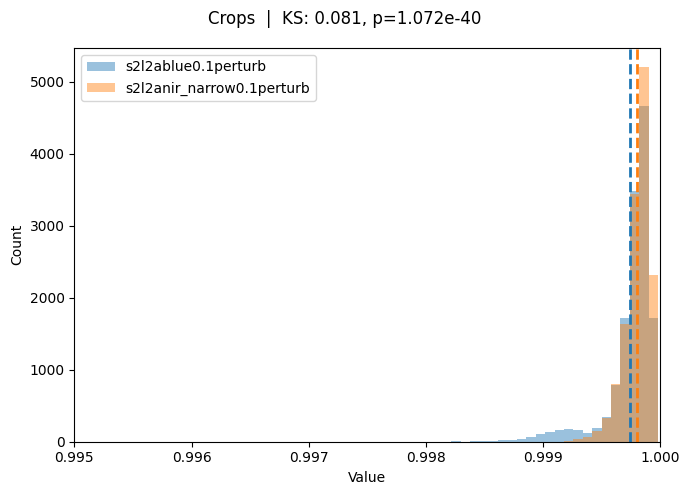

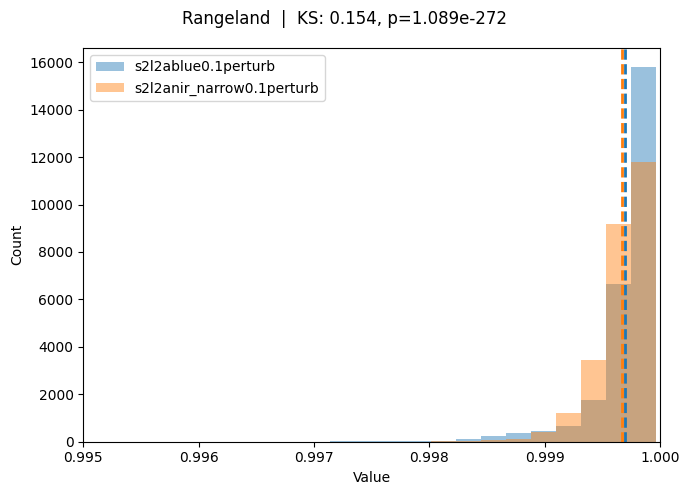

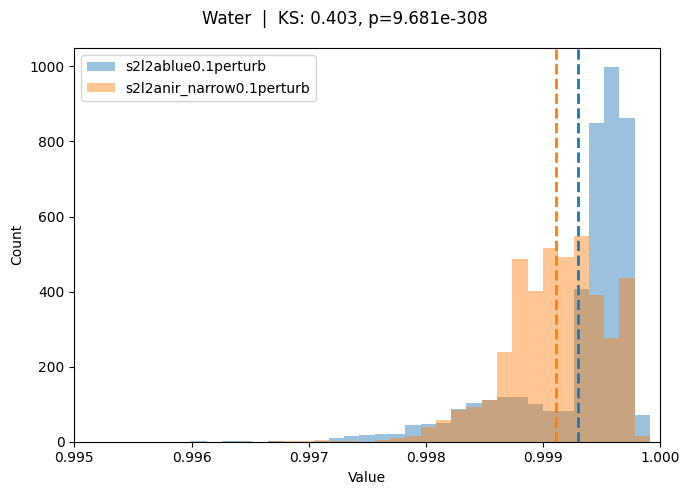

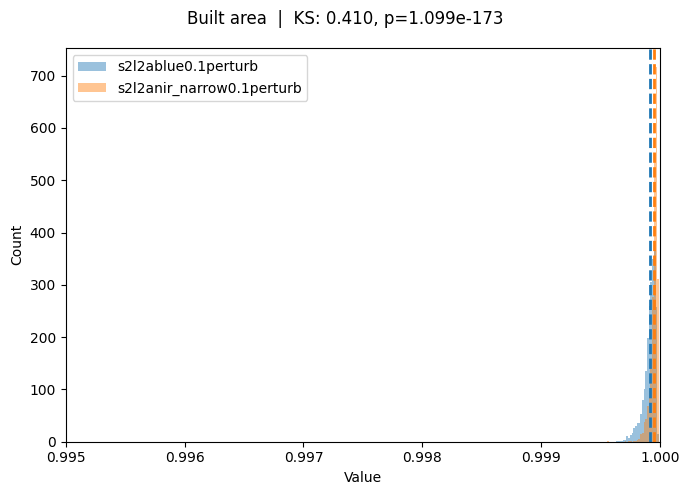

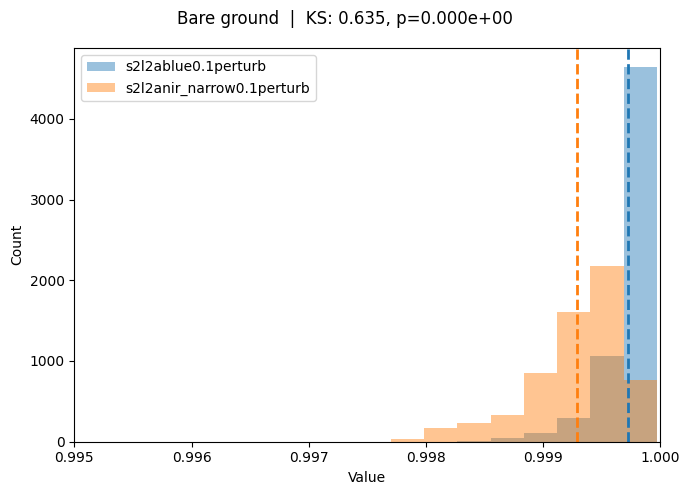

In [39]:
from scipy.stats import ks_2samp

for category in chip_gdf["category"].unique():
    category_df = chip_gdf[chip_gdf["category"] == category]
    cols = list(cosine_simalarities.keys())
    combined = np.concatenate([category_df[col].to_numpy() for col in cols])
    bins = np.histogram_bin_edges(combined, bins=30)

    plt.figure(figsize=(7, 5))
    for col, color in zip(cols, ["#1f77b4", "#ff7f0e"]):
        plt.hist(category_df[col], bins=bins, alpha=0.45, color=color, label=col)
        plt.axvline(category_df[col].mean(), color=color, linestyle="--", linewidth=2)

    ks_stat, ks_p = ks_2samp(category_df[cols[0]], category_df[cols[1]])
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.xlim(0.995, 1)
    plt.legend()
    plt.suptitle(f"{category}  |  KS: {ks_stat:.3f}, p={ks_p:.3e}")
    plt.tight_layout()
    plt.show()

## Extract embeddings and calculate cosine similarity between ablated embeddings and non-ablated embeddings

## Visualize per-class cosine similarity based on ablated and non-ablated embeddings

## Use a KS Test to determine statistical significance of distubrances separated by class